#### Obtaining rainfall data in NETCDF format and using XArray, Dask and other geospatial libraries to perform analysis

In [1]:
import dask
import dask.array as da
import xarray as xr
import rioxarray as rx
import rasterio
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import cftime
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

##### Fille paths to read data 

In [9]:
ind2018_nc = '.data/netcdf/RF25_ind2018_rfp25.nc'
geojson_path = './data/geojson/kerala_boundary.geojson'
kerala_districts = './data/geojson/kerala_districts.geojson'

##### Open the NetCDF file using rioxarray


In [44]:
imd_daily_2018 = rx.open_rasterio(ind2018_nc, masked=True)
# Define the WGS84 CRS
wgs84_crs = "+proj=longlat +datum=WGS84 +no_defs"
# Write CRS
imd_daily_2018.rio.write_crs(wgs84_crs,inplace=True)
imd_daily_2018.rio.crs

CRS.from_wkt('GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

#### Read GeoJSON and use it to clip Xarray dataset to study area

In [10]:
gdf = gpd.read_file(geojson_path)
district_gdf = gpd.read_file(kerala_districts)
geometry = shape(gdf.geometry.iloc[0])

In [ ]:
# Clip the rioxarray dataset 
clipped_imd_daily = imd_ds.rio.clip([geometry], drop =True)
# save the result to a new file
#clipped_imd_daily.to_netcdf('kerala_imd_daily_2018.nc')

In [11]:
# file path to clipped netCDF
imd_kerala_2018 = './data/netcdf/kerala_imd_daily_2018.nc'
# Open the NetCDF file using rioxarray
kerala_imd_ds = rx.open_rasterio(imd_kerala_2018, masked=True,chunks={'TIME': 'auto'})
datetimeindex = kerala_imd_ds.indexes['TIME'].to_datetimeindex()
kerala_imd_ds['TIME'] = datetimeindex

#### Group data by month

In [22]:
kerala_imd_monthly_2018 = kerala_imd_ds.groupby('TIME.month').sum(dim='TIME', skipna=True)

In [23]:
# Replace all 0 values with NaN
kerala_imd_monthly_2018 = kerala_imd_monthly_2018.where(kerala_imd_monthly_2018 != 0)

In [24]:
kerala_imd_monthly_2018_flatten = kerala_imd_monthly_2018.mean(dim=['x', 'y'], skipna=True)

In [25]:
kerala_imd_monthly_pd = kerala_imd_monthly_2018_flatten.to_dataframe()

In [ ]:
kerala_imd_monthly_pd

#### Read CSV with Monthly mean values

In [28]:
file_path = './data/csv/kerala_precip.csv'
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

#### Plot Monthly Rainfall data

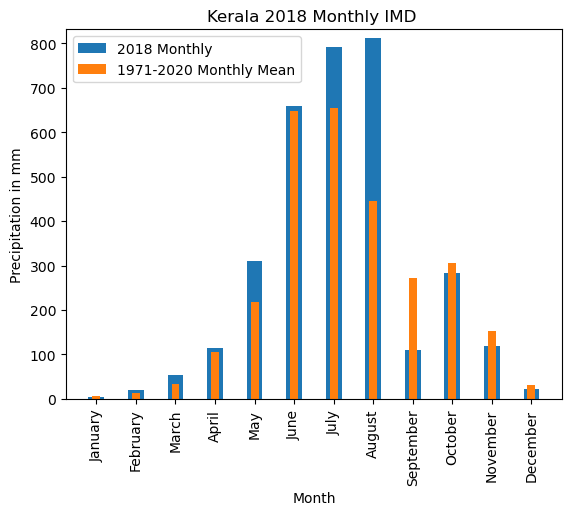

In [29]:
x_values = kerala_imd_monthly_pd.index
y1_values =  kerala_imd_monthly_pd['RAINFALL']
# Get monthly mean values from CSV
y2_values = df[:1].values.tolist()[0][2:][:-1]

plt.bar(x_values, y1_values, width = 0.4, label = '2018 Monthly')
plt.bar(x_values, y2_values, width = 0.2, label = '1971-2020 Monthly Mean')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',  'August', 'September', 'October', 'November', 'December'] 

# Add labels and legend
plt.xlabel('Month')

plt.xticks(x_values, months, rotation=90)
# Set the y-axis to start from 0
plt.ylim(0, max(y1_values) + 20)

plt.ylabel('Precipitation in mm')
plt.title('Kerala 2018 Monthly IMD ')
plt.legend()

# Show the plot
plt.show()

#### Calculate total monsoon rainfall

In [30]:
# Filter the dataset to include only monsoon months 6, 7, 8, 9
kerala_monsoon_imd = kerala_imd_ds.sel(TIME=kerala_imd_ds['TIME'].dt.month.isin([6, 7, 8, 9]))
kerala_monsoon_2018 = kerala_monsoon_imd.sum(dim=['TIME'], skipna=True)

#### Plot Monsoon Rainfall data

/tmp/ipykernel_1780/179112651.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):


Text(0.5, 1.0, 'Kerala 2018 Monsoon Rainfall IMD')

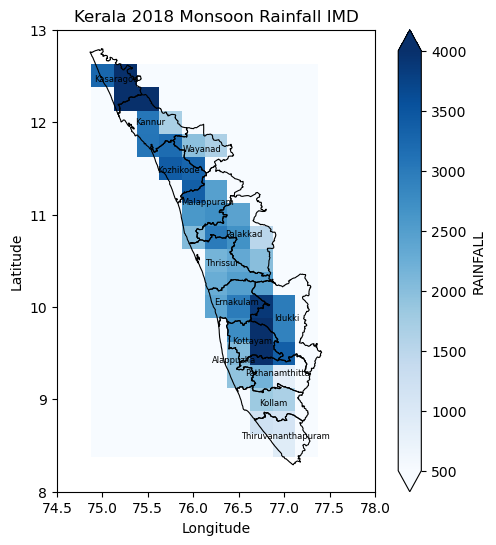

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
district_gdf.boundary.plot(ax =ax, color='black',linewidth=0.8 )
kerala_monsoon_2018.plot(ax=ax, cmap='Blues', vmin=500, vmax=4000)
# Add labels for each district
for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):
    ax.text(x, y, label, fontsize=6,color= 'black', ha='center', va='center')
ax.set_xlim([74.5, 78])  # Adjust the longitude range
ax.set_ylim([8, 13])   # Adjust the latitude range
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kerala 2018 Monsoon Rainfall IMD')

#### Get Daily Maximum values across the study area

In [50]:
kerala_monsoon_2018_daily_max = kerala_monsoon_imd.max(dim=['x', 'y'], skipna=True)
kerala_monsoon_2018_daily_max_pd = kerala_monsoon_2018_daily_max.to_dataframe()

In [48]:
np.max(kerala_monsoon_2018_daily_max_pd['RAINFALL'])

301.1153869628906

#### Plot Daily Maximum Rainfall with Thresholds

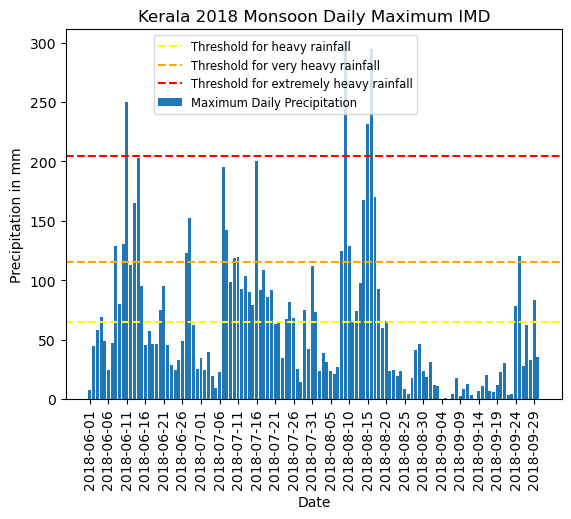

In [51]:
x_values = kerala_monsoon_2018_daily_max_pd.index.date
y1_values = kerala_monsoon_2018_daily_max_pd['RAINFALL']

# Plot the data
plt.bar(x_values, y1_values, label = 'Maximum Daily Precipitation')
# Add horizontal lines at thresholds
plt.axhline(y=64.5, color='yellow', linestyle='--', label='Threshold for heavy rainfall')
plt.axhline(y=115.5, color='orange', linestyle='--', label='Threshold for very heavy rainfall')
plt.axhline(y=204.5, color='red', linestyle='--', label='Threshold for extremely heavy rainfall')

# Add labels and legend
plt.xlabel('Date')
plt.xticks(x_values[::5], x_values[::5], rotation=90)
# Set the y-axis to start from 0
plt.ylim(0, max(y1_values) + 10)

plt.ylabel('Precipitation in mm')
plt.title('Kerala 2018 Monsoon Daily Maximum IMD')
plt.legend(bbox_to_anchor=(0.72, 1), loc='upper right', fontsize='small')
plt.show()


In [52]:
heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 64.5).sum()
very_heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 115.5).sum()
extremely_heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 204.5).sum()

In [53]:
heavy_precip,very_heavy_precip,extremely_heavy_precip

(48, 20, 4)